In [239]:
import pandas as pd
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [240]:
stemmer = PorterStemmer()

In [243]:
# tdf = pd.read_csv('transcripts/transcripts.csv', index_col=0)
# sdf = pd.read_csv('transcripts/speeches.csv', index_col=0)
# tdf = pd.read_csv('transcripts/transcripts_sents.csv', index_col=0)
# sdf = pd.read_csv('transcripts/speech_sents.csv', index_col=0)
tdf = pd.read_csv('transcripts_enhanced.csv')
sdf = pd.read_csv('speeches_enhanced.csv')

In [244]:
sdf['tokens'] = sdf['text_enhanced'].apply(lambda x: utils.process(x, stemmer=stemmer))

In [245]:
tdf['tokens'] = tdf['text_enhanced'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [246]:
texts = tdf['tokens'].tolist() + sdf['tokens'].tolist()

In [7]:
len(texts)

525204

In [247]:
dictionary = Dictionary(texts)

# dictionary.filter_n_most_frequent(10)
# dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

### EVENTUALLY USE MORE SOPHISTICATED PROCEDURE TO SELECT NUMBER OF TOPICS

In [ ]:
def coherence_compare(corpus, start, stop, step):
    for i in range(start, stop, step):
        lda = LdaModel(corpus, i, id2word=dictionary, passes=1)
        cm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary)
        print(cm.get_coherence())
coherence_compare(corpus, 2, 4, 3)

In [288]:
ldamodel = LdaModel(corpus, num_topics=30, id2word=dictionary, passes=1)

In [66]:
ldamodel.save('lda-40topics-111523')

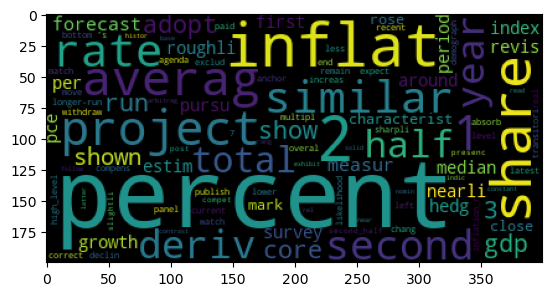

In [303]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(14, 200))))

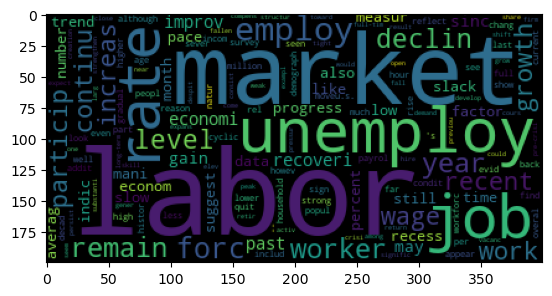

In [110]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(6, 200))))

In [93]:
ldamodel.show_topics(40)

[(0,
  '0.052*"``" + 0.047*"\'\'" + 0.031*"think" + 0.022*"n\'t" + 0.022*"--" + 0.015*"go" + 0.013*"\'s" + 0.010*"say" + 0.010*"us" + 0.010*"one"'),
 (1,
  '0.239*"2011" + 0.228*"2010" + 0.087*"mass" + 0.059*"chart" + 0.046*"fisher" + 0.022*"quick" + 0.021*"\'novemb" + 0.014*"mester" + 0.013*"fan" + 0.013*"pianalto"'),
 (2,
  '0.197*"reserv" + 0.190*"feder" + 0.046*"bank" + 0.028*"system" + 0.019*"board" + 0.017*"\'s" + 0.016*"fed" + 0.015*"oper" + 0.012*"market" + 0.009*"financ"'),
 (3,
  '0.073*"growth" + 0.047*"product" + 0.024*"invest" + 0.022*"year" + 0.019*"demand" + 0.016*"gdp" + 0.015*"increas" + 0.014*"real" + 0.012*"spend" + 0.011*"capit"'),
 (4,
  '0.251*"presid" + 0.173*"\'thank" + 0.093*"chairman" + 0.049*"laughter" + 0.038*"evan" + 0.032*"mr." + 0.014*"approv" + 0.013*"motion" + 0.012*"amen" + 0.012*"mr"'),
 (5,
  '0.394*"new" + 0.085*"york" + 0.036*"street" + 0.031*"2008" + 0.026*"sharehold" + 0.025*"wall" + 0.023*"act" + 0.023*"gse" + 0.019*"brother" + 0.018*"transfer"'

In [94]:
def get_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    if len(topic_probs) > 0:
        max_prob = topic_probs[0][1]
        max_ind = 0
        for i in range(1, len(topic_probs)):
            if topic_probs[i][1] > max_prob:
                max_prob = topic_probs[i][1]
                max_ind = i
        return pd.Series([topic_probs[max_ind][0], max_prob], index=['topic', 'prob'])
    return pd.Series([None, None], index=['topic', 'prob'])

get_topics(tdf.loc[205].tokens)

topic    31.000000
prob      0.394183
dtype: float64

In [103]:
tdf.loc[200].condensed

'We could do zero.'

In [95]:
tdf[['topic','topic_prob']] = tdf.tokens.apply(get_topics)

In [106]:
sdf[['topic', 'topic_prob']] = sdf.tokens.apply(get_topics)

In [ ]:
for item in sdf[sdf['topic'] == 6.0]['text'][:25]:
    print(item)

In [ ]:
for item in tdf[tdf['topic'] == 6.0]['condensed'][:25]:
    print(item)

In [ ]:
for item in tdf[tdf['topic'] == 3.0]['condensed'][:25]:
    print(item)

In [ ]:
for item in sdf[sdf['topic'] == 3.0]['text'][:25]:
    print(item)

In [114]:
path = "Loughran-McDonald_MasterDictionary_1993-2021.csv"

lm_df = pd.read_csv(path)

lm = {}

for i, row in lm_df.iterrows():
    # print(row)
    word = str(row['Word']).lower()
    if row['Negative'] != 0:
        lm[word] = -1
    if row['Positive'] != 0:
        lm[word] = 1

In [196]:
def sentscore(string):
    # tokens = process(string)
    total = 0
    tokens = [token.lower() for token in word_tokenize(str(string))]
    for token in tokens:
        # print(token)
        if token in lm:
            total += lm[token]
            # print(token)
            # print(lm[token])
    # print(total)
    # print(tokens)
    return total / len(tokens)

In [197]:
tdf['lm_sent'] = tdf['condensed'].apply(sentscore)

In [198]:
sdf['lm_sent'] = sdf['text'].apply(sentscore)

In [247]:
speech_infl = sdf[sdf['topic'] == 6][['date', 'lm_sent']]
speech_infl['date'] = pd.to_datetime(speech_infl['date'])
sinfdf = speech_infl.groupby(pd.PeriodIndex(speech_infl['date'], freq='M'))['lm_sent'].mean()

In [248]:
transcript_infl = tdf[tdf['topic'] == 6][['date', 'lm_sent']]
transcript_infl['date'] = pd.to_datetime(transcript_infl['date'])
tinfdf = transcript_infl.groupby(pd.PeriodIndex(transcript_infl['date'], freq='M'))['lm_sent'].mean()

In [232]:
speech_grow = sdf[sdf['topic'] == 3][['date', 'lm_sent']]
speech_grow['date'] = pd.to_datetime(speech_grow['date'])
sgrowdf = speech_grow.groupby(pd.PeriodIndex(speech_grow['date'], freq='M'))['lm_sent'].mean()

In [236]:
transcript_grow = tdf[tdf['topic'] == 3][['date', 'lm_sent']]
transcript_grow['date'] = pd.to_datetime(transcript_grow['date'])
tgrowdf = transcript_grow.groupby(pd.PeriodIndex(transcript_grow['date'], freq='M'))['lm_sent'].mean()

In [ ]:
merged_inf = pd.merge(sinfdf, tinfdf, on='date', suffixes=['_speeches', '_transcripts'])
merged_inf.plot()
# merged_inf

In [ ]:
merged_grow = pd.merge(sgrowdf, tgrowdf, on='date', suffixes=['_speeches', '_transcripts'])
merged_grow.plot()